# Random Forest Classifier
**4.0 Random Forest classifier** This trains a random Forest classifier using High Level Features. It performs very well in terms of speed and accuracy.

To run this notebook we used the following configuration:
* *Software stack*: Spark 2.4.1
* *Platform*: CentOS 7, Python 3.6
* *Spark cluster*: Analytix

In [1]:
# pip install pyspark or use your favorite way to set Spark Home, here we use findspark
import findspark
findspark.init('/home/luca/Spark/spark-2.4.1-bin-hadoop2.7') #set path to SPARK_HOME

In [2]:
# Configure according to your environment
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("Training-RandomForestClassifier") \
        .master("yarn") \
        .config("spark.driver.memory","8g") \
        .config("spark.executor.memory","14g") \
        .config("spark.executor.cores","6") \
        .config("spark.executor.instances","40") \
        .config("spark.dynamicAllocation.enabled","false") \
        .config("spark.speculation","true") \
        .config("spark.eventLog.enabled","false") \
        .getOrCreate()

In [3]:
spark

## Load train and test dataframes

In [4]:
PATH = "hdfs://analytix/Training/Spark/TopologyClassifier/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled.parquet')\
        .select(['hfeatures_dense', 'label', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled.parquet')\
        .select(['hfeatures_dense', 'label', 'encoded_label'])

In [ ]:
# Optionally count the number of events in the training and test datasets
test_events = testDF.count()
train_events = trainDF.count()
print('There are', train_events, 'training events')
print('There are', test_events, 'test events')

In [5]:
trainDF.printSchema()

root
 |-- hfeatures_dense: vector (nullable = true)
 |-- label: long (nullable = true)
 |-- encoded_label: vector (nullable = true)



In [6]:
testDF.show(3)

+--------------------+-----+-------------+
|     hfeatures_dense|label|encoded_label|
+--------------------+-----+-------------+
|[0.0,1.4748330116...|    0|(3,[0],[1.0])|
|[0.0,5.8630452156...|    0|(3,[0],[1.0])|
|[0.0,6.9097003936...|    0|(3,[0],[1.0])|
+--------------------+-----+-------------+
only showing top 3 rows



## Train the Random Forest

In [7]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=100, maxDepth=10,
                            featuresCol='hfeatures_dense',
                            labelCol="label",
                            predictionCol='prediction')

In [8]:
%time rf_model = rf.fit(trainDF)

CPU times: user 47.7 ms, sys: 18.5 ms, total: 66.2 ms
Wall time: 3min 29s


## Save the model

In [9]:
rf_model.save(path='file:/tmp/models/RandomForest/rf_model')

In [80]:
# reload with:
# from pyspark.ml.classification import RandomForestClassificationModel
# rf_model = RandomForestClassificationModel.load('file:/tmp/models/RandomForest/rf_model')

## Prediction

In [10]:
pred = rf_model.transform(testDF)

In [11]:
pred.show(5)

+--------------------+-----+-------------+--------------------+--------------------+----------+
|     hfeatures_dense|label|encoded_label|       rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+--------------------+----------+
|[0.0,1.4748330116...|    0|(3,[0],[1.0])|[84.7331220822746...|[0.84733122082274...|       0.0|
|[0.0,5.8630452156...|    0|(3,[0],[1.0])|[82.9319521249406...|[0.82931952124940...|       0.0|
|[0.0,6.9097003936...|    0|(3,[0],[1.0])|[82.4970114414819...|[0.82497011441481...|       0.0|
|[0.0,7.8183388710...|    0|(3,[0],[1.0])|[31.4451618668702...|[0.31445161866870...|       2.0|
|[0.0,7.9835400581...|    0|(3,[0],[1.0])|[82.2913329025089...|[0.82291332902508...|       0.0|
+--------------------+-----+-------------+--------------------+--------------------+----------+
only showing top 5 rows



## Compute the AUC

In [12]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import udf
    
vector_udf = udf(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))
pred = pred.select([vector_udf('encoded_label').alias('encoded_label'),
                    vector_udf('probability').alias('probability')])

In [13]:
%time pred_pd = pred.select(['encoded_label', 'probability']).toPandas()

CPU times: user 3.91 s, sys: 392 ms, total: 4.3 s
Wall time: 25.7 s


In [14]:
pred_pd.head()

,encoded_label,probability
0,"[1.0, 0.0, 0.0]","[0.8473312208227461, 0.005744755970733107, 0.1..."
1,"[1.0, 0.0, 0.0]","[0.8293195212494068, 0.007398729563067694, 0.1..."
2,"[1.0, 0.0, 0.0]","[0.8249701144148193, 0.0064988603220727985, 0...."
3,"[1.0, 0.0, 0.0]","[0.3144516186687028, 0.02009966854306029, 0.66..."
4,"[1.0, 0.0, 0.0]","[0.8229133290250892, 0.006199286112961962, 0.1..."


In [15]:
import numpy as np
y_true = np.array(pred_pd['encoded_label'].tolist())
y_pred = np.array(pred_pd['probability'].tolist())

In [16]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


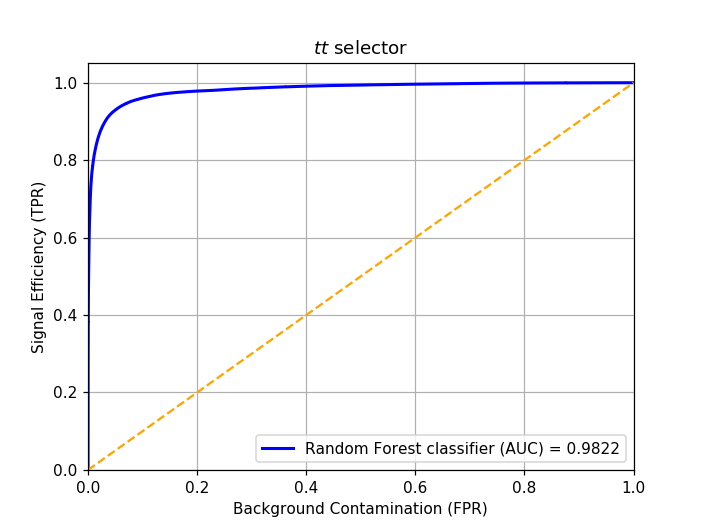

In [18]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure()
plt.plot(fpr[1], tpr[1], color='blue', 
         lw=2, label='Random Forest classifier (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


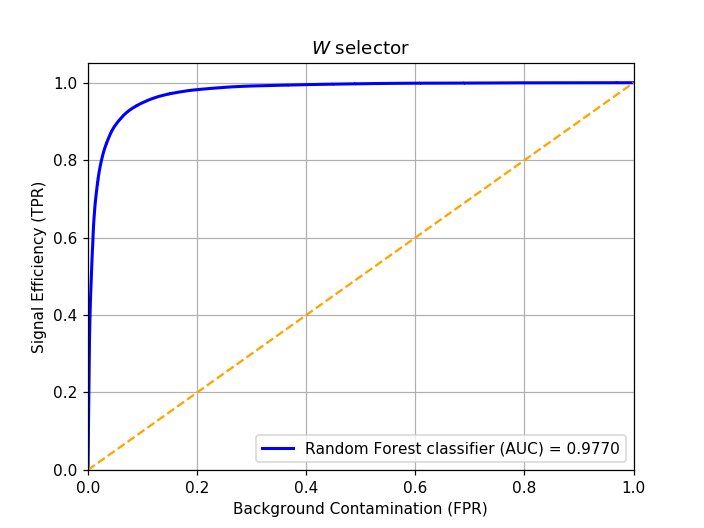

In [19]:
plt.figure()
plt.plot(fpr[2], tpr[2], color='blue', 
         lw=2, label='Random Forest classifier (AUC) = %0.4f' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Confusion Matrix

In [20]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9079


<IPython.core.display.Javascript object>


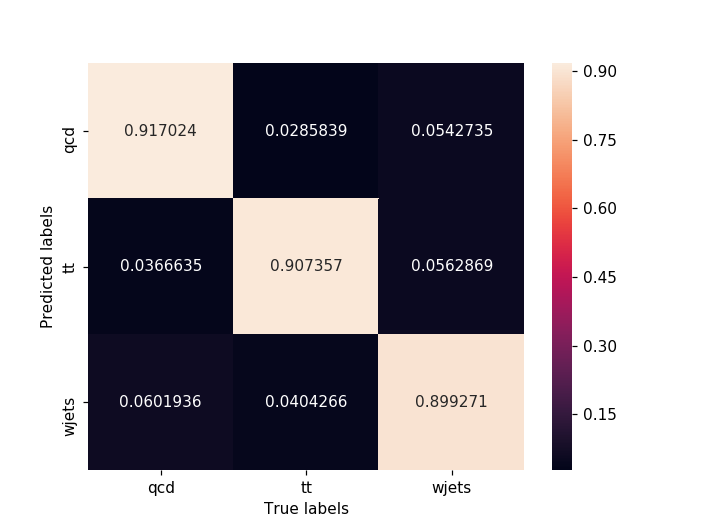

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()